PG | sample: 1970-01-05 → 2026-02-18 | n=14152 days
Historical VaR (95%, 1d): 1.9872%
Normal VaR      (95%, 1d): 2.2484%
Mean: 0.0429%  Vol: 1.3930%

Rolling 252d backtest (1d ahead, 95% VaR):
Expected exception rate: 5.0%
Historical exceptions:   5.45%   (758 / 13900)
Normal exceptions:       4.60%   (640 / 13900)


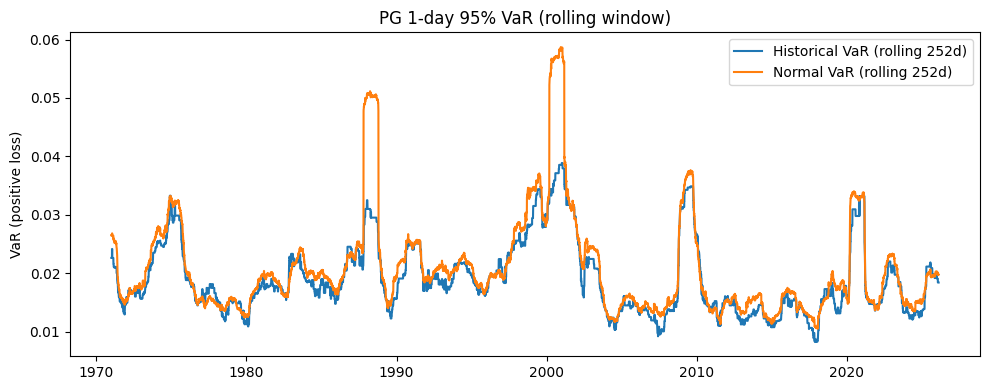

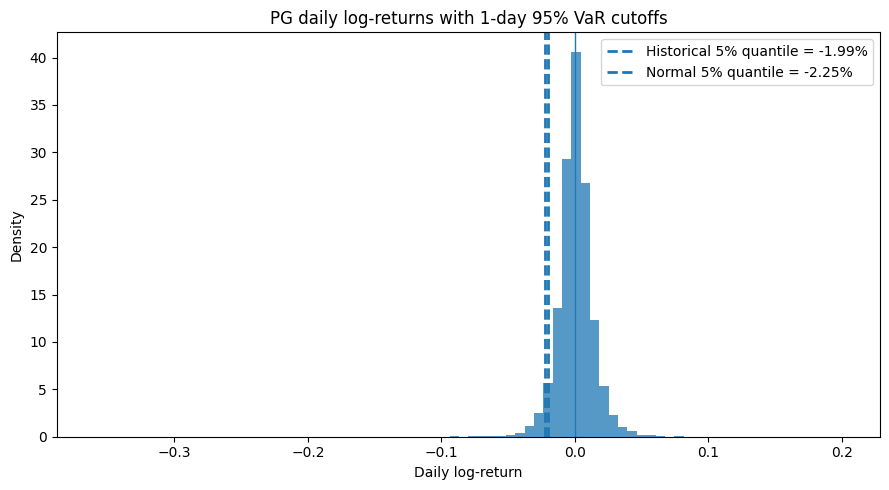

In [14]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

ticker = "PG"
start = "1970-01-01"
alpha = 0.05
z_alpha = -1.6448536269514729  # Phi^{-1}(0.05) for N(0,1)

px = yf.download(ticker, start=start, auto_adjust=True, progress=False)["Close"].dropna().squeeze()
r = np.log(px).diff().dropna()   # daily log-returns (Series)

# Single-number VaR (full sample)
q_emp = float(np.quantile(r.values, alpha))
var_hist = -q_emp

mu = float(r.mean())
sigma = float(r.std(ddof=1))
q_norm = mu + sigma * z_alpha
var_norm = -q_norm

# Rolling VaR + backtest (1-day ahead)
w = 252
if len(r) < w + 5:
    raise ValueError(f"Not enough data for a {w}-day rolling window.")

q_emp_roll = r.rolling(w).quantile(alpha)
mu_roll = r.rolling(w).mean()
sigma_roll = r.rolling(w).std(ddof=1)

var_hist_1d = (-q_emp_roll).shift(1) # forecast for day t uses info up to t-1
var_norm_1d = (-(mu_roll + sigma_roll * z_alpha)).shift(1)

bt = (r.rename("r").to_frame()
      .join(var_hist_1d.rename("vh"))
      .join(var_norm_1d.rename("vn"))
      .dropna())

bh = bt["r"] < -bt["vh"]
bn = bt["r"] < -bt["vn"]

print(f"{ticker} | sample: {r.index.min().date()} → {r.index.max().date()} | n={len(r)} days")
print(f"Historical VaR (95%, 1d): {var_hist:.4%}")
print(f"Normal VaR      (95%, 1d): {var_norm:.4%}")
print(f"Mean: {mu:.4%}  Vol: {sigma:.4%}")

print(f"\nRolling {w}d backtest (1d ahead, 95% VaR):")
print(f"Expected exception rate: {alpha:.1%}")
print(f"Historical exceptions:   {bh.mean():.2%}   ({bh.sum()} / {len(bh)})")
print(f"Normal exceptions:       {bn.mean():.2%}   ({bn.sum()} / {len(bn)})")

# Plots
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(bt.index, bt["vh"].values, label=f"Historical VaR (rolling {w}d)")
ax.plot(bt.index, bt["vn"].values, label=f"Normal VaR (rolling {w}d)")
ax.set_title(f"{ticker} 1-day 95% VaR (rolling window)")
ax.set_ylabel("VaR (positive loss)")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(9, 5))
ax.axvline(0.0, linewidth=1)
ax.hist(r.values, bins=80, density=True, alpha=0.75)
ax.axvline(q_emp,  linestyle="--", linewidth=2, label=f"Historical 5% quantile = {q_emp:.2%}")
ax.axvline(q_norm, linestyle="--", linewidth=2, label=f"Normal 5% quantile = {q_norm:.2%}")
ax.set_title(f"{ticker} daily log-returns with 1-day 95% VaR cutoffs")
ax.set_xlabel("Daily log-return")
ax.set_ylabel("Density")
ax.legend()
plt.tight_layout()
plt.show()

